In [1]:
from __future__ import print_function, division
%run basics.ipynb

Populating the interactive namespace from numpy and matplotlib


Loading BokehJS ...

Using Theano backend.


In [2]:
df = pd.read_pickle('udacity_courses.df')
print(len(df))
print(df.columns)
df.head(2)

129
Index([u'id', u'title', u'homepage', u'subtitle', u'level', u'starter',
       u'image', u'banner_image', u'teaser_video', u'summary',
       u'short_summary', u'required_knowledge', u'expected_learning',
       u'featured', u'syllabus', u'faq', u'full_course_available',
       u'expected_duration', u'expected_duration_unit', u'new_release',
       u'transcripts_url', u'transcripts_zip_fn', u'transcript'],
      dtype='object')


,id,title,homepage,subtitle,level,starter,image,banner_image,teaser_video,summary,...,featured,syllabus,faq,full_course_available,expected_duration,expected_duration_unit,new_release,transcripts_url,transcripts_zip_fn,transcript
0,bio110,Tales from the Genome,https://www.udacity.com/course/tales-from-the-...,Introduction to Genetics for Beginners,beginner,False,https://lh5.ggpht.com/Fh07_XbT61CGDWsQoOMQaIeH...,https://lh4.ggpht.com/_AHqr0EXcLBzF0rrwtBagE0t...,https://www.youtube.com/watch?v=sEXrjh-tme8,This course is a journey into the biology of t...,...,False,## Lesson 1: Introduction to traits and heredi...,NaN,False,3,months,False,https://www.udacity.com/course/progress#!/c-bi...,transcripts_zips/bio110.zip,In the same way that our genomes influence tr...
1,cs046,Intro to Java Programming,https://www.udacity.com/course/intro-to-java-p...,Building Programs with Classes & Objects,beginner,False,https://lh4.ggpht.com/9ytiUdz0QYHwuMJFTXcNXZn4...,https://lh3.ggpht.com/AdAALPYhCsWuIvDl0ZY6zIW2...,https://www.youtube.com/watch?v=Wsp5Rrenoq4,"In this introductory course, you'll learn and ...",...,False,"### Lesson 1: Introduction to Computers, Progr...",NaN,True,4,months,False,https://www.udacity.com/course/progress#!/c-cs046,transcripts_zips/cs046.zip,"Hi, I'm Cay. I'm Sara. We'll be the instructo..."


In [3]:
df_prereq = pd.read_csv('udacity_prereq_graph.csv')
df_prereq.head(2)

,u_id,u_pre_req_id
0,cs222,cs101
1,cs222,ph100


In [4]:
print('self prereq:', (df_prereq['u_id'] == df_prereq['u_pre_req_id']).sum())

self prereq: 2


In [5]:
print(df_prereq[df_prereq['u_id'] == 'ud257'])

     u_id u_pre_req_id
23  ud257        ud201
24  ud257        ud827


In [6]:
set_cids = set(df_prereq['u_pre_req_id'])
df_prereq['in_u_id'] = df_prereq['u_pre_req_id'].apply(lambda x: x in set_cids)
df_prereq['in_u_id'].value_counts()

True    118
Name: in_u_id, dtype: int64

In [7]:
prereq_counts = sorted(Counter(df_prereq['u_pre_req_id'].values).items(), key=itemgetter(1), reverse=True)
print(prereq_counts[:10])

[('ud775', 16), ('cs101', 13), ('ud853', 13), ('ud804', 8), ('ud036', 8), ('ud855', 8), ('ud304', 6), ('ud827', 5), ('ud201', 4), ('cs046', 4)]


In [8]:
df_prereq = pd.DataFrame(columns=[0], data=df_prereq.groupby(by='u_id').apply(lambda x: ' '.join(x['u_pre_req_id'].values)))

def resolve_course_titles(element, c_df):
    if isinstance(element, float):
        return np.nan
    t = np.nan
    try:
        t = c_df[c_df['id']==element].iloc[0]['title']
    except IndexError:
        pass
    return t

df_prereq['c_title'] = map(lambda x: resolve_course_titles(x, df), df_prereq.index)


def resolve_prereq_titles(element, c_df):
    if isinstance(element, float):
        return np.nan
    t = list()
    for i in element.split():
        try:
            t.append(c_df[c_df['id']==i].iloc[0]['title'])
        except IndexError:
            pass
    return ' ,'.join(t)

df_prereq['p_titles'] = df_prereq[0].apply(resolve_prereq_titles, args=(df ,))

In [9]:
for idx, row in df_prereq.iloc[:20].iterrows():
    print(row['c_title'])
    for p in row['p_titles'].split(','):
        print('\t', p)

Differential Equations in Action
	 Intro to Computer Science 
	 Intro to Physics 
	 Programming Foundations with Python
Web Development
	 Intro to Computer Science 
	 Programming Foundations with Python
Intro to Artificial Intelligence
	 Intro to Statistics
Intro to Theoretical Computer Science
	 Intro to Computer Science 
	 Intro to Algorithms
Artificial Intelligence for Robotics
	 Intro to Computer Science
Firebase Essentials For Android
	 Firebase Essentials For Android
Object-Oriented JavaScript
	 JavaScript Basics
Intro to Machine Learning
	 Intro to Computer Science 
	 Intro to Inferential Statistics 
	 Intro to Data Science 
	 How to Use Git and GitHub 
	 Intro to Descriptive Statistics
Intro to Data Analysis
	 Intro to Computer Science 
	 Programming Foundations with Python
Intro to Relational Databases
	 Programming Foundations with Python 
	 How to Use Git and GitHub
Intro to Inferential Statistics
	 Intro to Descriptive Statistics
Intro to jQuery
	 Intro to HTML and CSS 
	 J

In [10]:
df_prereq.drop(['p_titles', 'c_title'], inplace=True, axis=1)

In [11]:
def find_next_level_prereq(row, col, df):
    prereq = ''
    already_in = set()
    for i in row:
        if isinstance(i, float):
            break
        already_in.update(set(i.split()))
    last_element = row.iloc[-1]
    if isinstance(last_element, float):
        return np.nan
    # print(last_element)
    for i in last_element.split():
        try:
            new_prereq = df.at[i, col]
            if not isinstance(new_prereq, float):
                new_prereq = ' '.join(filter(lambda x: x not in already_in, new_prereq.split()))
                prereq += new_prereq
        except KeyError:
            pass
    if prereq == '':
        return np.nan
    return prereq

def add_prereq_level(df):
    max_level = max(df.columns)
    df[max_level + 1] = df.apply(find_next_level_prereq, args=(max_level, df), axis=1)

for i in range(2):
    add_prereq_level(df_prereq)
    print(df_prereq[df_prereq.columns[-1]].isnull().sum()/len(df_prereq))
df_prereq.head(10)

0.5
0.931034482759


,0,1,2
u_id,,,
cs222,cs101 ph100 ud036,NaN,NaN
cs253,cs101 ud036,NaN,NaN
cs271,st101,NaN,NaN
cs313,cs101 cs215,NaN,NaN
cs373,cs101,NaN,NaN
ud009,ud009,NaN,NaN
ud015,ud804,cs101 ud036,NaN
ud120,cs101 ud201 ud359 ud775 ud827,ud595,ud036 ud197
ud170,cs101 ud036,NaN,NaN


In [12]:
df.head(2)

,id,title,homepage,subtitle,level,starter,image,banner_image,teaser_video,summary,...,featured,syllabus,faq,full_course_available,expected_duration,expected_duration_unit,new_release,transcripts_url,transcripts_zip_fn,transcript
0,bio110,Tales from the Genome,https://www.udacity.com/course/tales-from-the-...,Introduction to Genetics for Beginners,beginner,False,https://lh5.ggpht.com/Fh07_XbT61CGDWsQoOMQaIeH...,https://lh4.ggpht.com/_AHqr0EXcLBzF0rrwtBagE0t...,https://www.youtube.com/watch?v=sEXrjh-tme8,This course is a journey into the biology of t...,...,False,## Lesson 1: Introduction to traits and heredi...,NaN,False,3,months,False,https://www.udacity.com/course/progress#!/c-bi...,transcripts_zips/bio110.zip,In the same way that our genomes influence tr...
1,cs046,Intro to Java Programming,https://www.udacity.com/course/intro-to-java-p...,Building Programs with Classes & Objects,beginner,False,https://lh4.ggpht.com/9ytiUdz0QYHwuMJFTXcNXZn4...,https://lh3.ggpht.com/AdAALPYhCsWuIvDl0ZY6zIW2...,https://www.youtube.com/watch?v=Wsp5Rrenoq4,"In this introductory course, you'll learn and ...",...,False,"### Lesson 1: Introduction to Computers, Progr...",NaN,True,4,months,False,https://www.udacity.com/course/progress#!/c-cs046,transcripts_zips/cs046.zip,"Hi, I'm Cay. I'm Sara. We'll be the instructo..."


In [13]:
pd.unique(df['level'])

array(['beginner', 'advanced', 'intermediate', nan], dtype=object)

In [14]:
from collections import defaultdict
c_level = defaultdict(lambda: 3, ((j, i) for i,j in enumerate(pd.unique(df['level']))))
c_level[np.nan] = 3
c_level['nan'] = 3
c_level

defaultdict(<function __main__.<lambda>>,
            {nan: 3,
             'advanced': 1,
             'beginner': 0,
             'intermediate': 2,
             'nan': 3})

In [15]:
#df['all-text'] = df['title'] + ' ' + df['subtitle'] + ' ' + df['description'] + ' ' + df['short_description'] + ' ' + df['syllabus']
cols = ['title', 'subtitle', 'summary', 'expected_learning', 'syllabus', 'transcript']
df['all-text'] = ''
for i in cols:
    df['all-text'] += df[i].astype('str')
    df['all-text'] += ' '
df['all-text'].tail(10)

119    JavaScript Promises Async Work Made Easy Learn...
120    Offline Web Applications Using IndexedDB & Ser...
121    Learn Swift Programming Syntax From Optionals ...
122    Educational Technology Offered at Georgia Tech...
123    Model Building and Validation Advanced Techniq...
124    Introduction to Operating Systems Offered at G...
125    Linear Algebra Refresher Course A Brief Refres...
126    Computational Photography Offered at Georgia T...
127    JavaScript Design Patterns Organizing Code in ...
128    Learn Backbone.js Write Organized JavaScript A...
Name: all-text, dtype: object

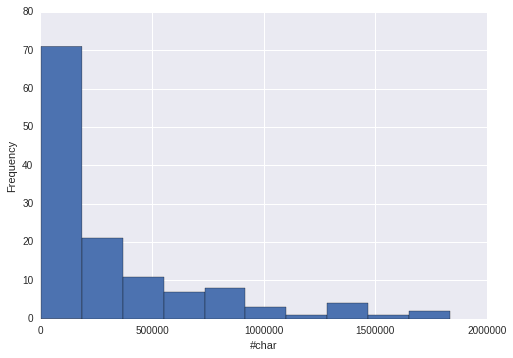

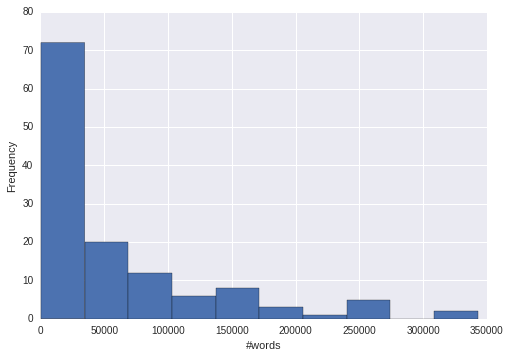

In [16]:
df['all-text'].apply(len).plot(kind='hist')
plt.xlabel('#char')
plt.show()
df['all-text'].apply(lambda x: len(x.split())).plot(kind='hist')
plt.xlabel('#words')
plt.show()

In [17]:
df['all-text'] = df['all-text'].apply(text_cleanup)
df.to_pickle('udacity_all_text.df')
df['title'] = df['title'].apply(text_cleanup)
df['transcript'] = df['transcript'].apply(text_cleanup)

tfidf shape: (129, 9172)
<type 'numpy.ndarray'>
(129, 9172)
2


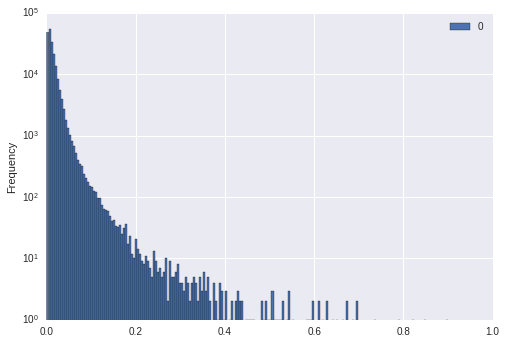

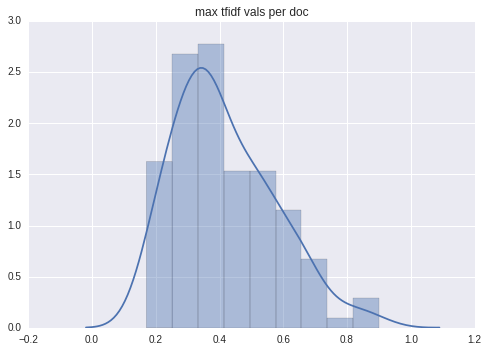

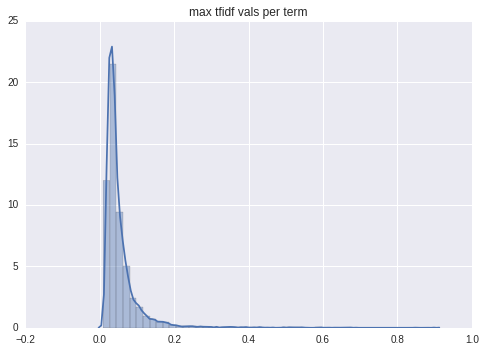

In [18]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=0.1, ngram_range=(2, 2))
#vectorizer = CountVectorizer(stop_words='english', max_df=0.1, min_df=5)
vectorized_text = vectorizer.fit_transform(df['all-text'].values)
print('tfidf shape:', vectorized_text.shape)

if False:
    from sklearn.decomposition import TruncatedSVD
    explained_var = list()
    comp_range = range(2, 1100, 100)
    shapes = list()
    for i in tqdm(reversed(comp_range)):
        svd = TruncatedSVD(n_components=i, n_iter=100)
        tmp = svd.fit_transform(vectorized_text)
        explained_var.append(svd.explained_variance_.sum())
        shapes.append(tmp.shape[1])
    pd.DataFrame(columns=['number of components', 'explained variance', 'true dim'], 
                 data=zip(comp_range, explained_var, shapes)).plot(x='number of components', secondary_y=['true dim'])
    plt.show()
    svd = TruncatedSVD(n_components=100, n_iter=100)
    vectorized_text = svd.fit_transform(vectorized_text)
else:
    vectorized_text = np.array(vectorized_text.todense())
print(type(vectorized_text))
print(vectorized_text.shape)
print(len(vectorized_text.shape))
plot_tfidf_vals(vectorized_text)

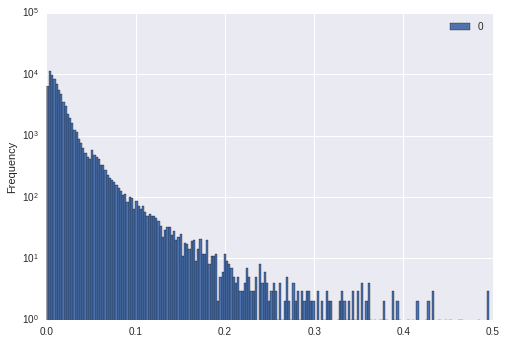

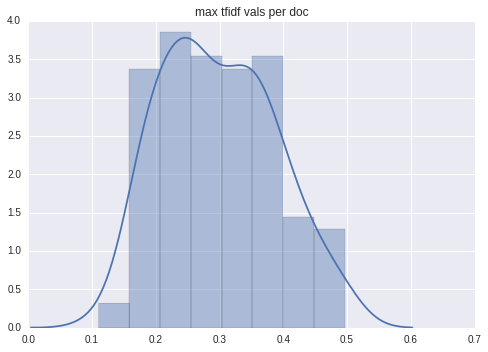

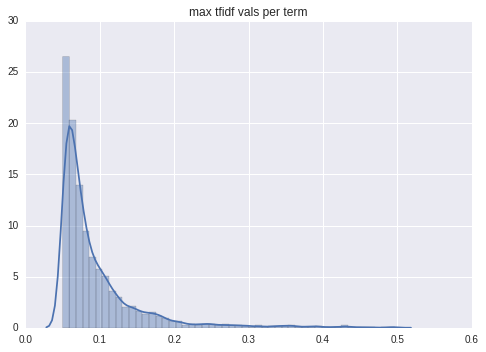

(129, 2980)
[u'computer programs' u'let add' u'different people' u'world just'
 u'input data' u'single day' u'worth mentioning' u'condition true'
 u'memory going' u'entire data' u'thing time' u'user data' u'memory need'
 u'question answer' u'takes string' u'tell difference' u'learn new'
 u'object just' u'statement ll' u'app does']


In [19]:
vectorized_text, words = filter_word_rep(vectorized_text, vectorizer.get_feature_names())

vectorized_text, words = filter_tfidf_max(vectorized_text, words, min_th=.05, max_th=0.5)
plot_tfidf_vals(vectorized_text)
print(vectorized_text.shape)
print(np.random.choice(words, size=20))

In [20]:
df.columns

Index([u'id', u'title', u'homepage', u'subtitle', u'level', u'starter',
       u'image', u'banner_image', u'teaser_video', u'summary',
       u'short_summary', u'required_knowledge', u'expected_learning',
       u'featured', u'syllabus', u'faq', u'full_course_available',
       u'expected_duration', u'expected_duration_unit', u'new_release',
       u'transcripts_url', u'transcripts_zip_fn', u'transcript', u'all-text'],
      dtype='object')

In [21]:
df[u'level'].isnull().sum()

1

In [22]:
df.dropna(axis='index', subset=[u'level'], inplace=True)
df[u'level'].isnull().sum()

0

In [23]:
df[u'level'].value_counts()

intermediate    66
advanced        32
beginner        30
Name: level, dtype: int64

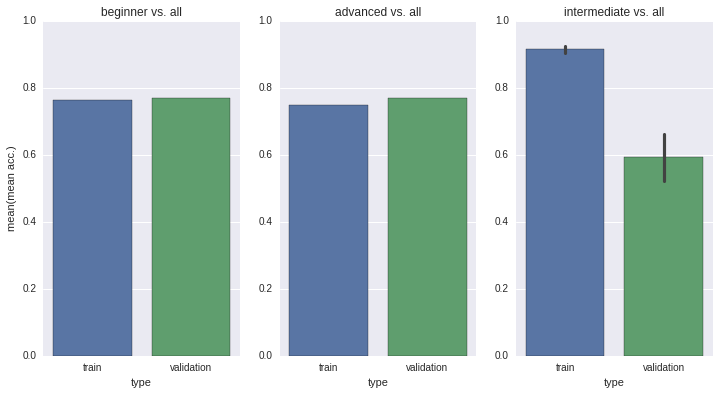

In [24]:
levels = pd.unique(df['level'])
fig, axes = plt.subplots(1, len(levels), figsize=(12, 6))
t_w = list()
words = vectorizer.get_feature_names()
for t_idx, target_class in enumerate(levels):
    y = (df['level'] == target_class).values
    r = list()
    #print('\n===========')
    #print(target_class)
    #print('------------')
    #print('\tpos\t\t\t\t\t\t')
    for train_idx, test_idx in StratifiedShuffleSplit(y, n_iter=10, test_size=0.1, random_state=2016):
        x_train = vectorized_text[train_idx, :]
        x_test = vectorized_text[test_idx, :]
        y_train = y[train_idx]
        y_test = y[test_idx]
        w_train = gen_weights(y_train)
        w_test = gen_weights(y_test)
        
        clf = MultinomialNB(alpha=1)
        clf.fit(x_train, y_train, w_train)
        r.append(('train', clf.score(x_train, y_train, w_train)))
        r.append(('validation', clf.score(x_test, y_test, w_test)))

        log_prob = clf.feature_log_prob_
           
        idx_p = sorted(enumerate(log_prob[1, :]), key=itemgetter(1), reverse=True)
        #print(', '.join(words[i[0]] for i in idx_p[:10]), end='')
        #print('\n\n\tneg')
        idx_p = sorted(enumerate(log_prob[0, :]), key=itemgetter(1), reverse=True)
        #print(', '.join(words[i[0]] for i in idx_p[:10]))
        #print('\n\n', end='')

    r = pd.DataFrame(columns=['type', 'mean acc.'], data=r)
    ax = axes[t_idx]
    sns.barplot(x='type', y='mean acc.', data=r, ax=ax)
    #ax.xticks(rotation=90)
    ax.set_title(target_class + " vs. all")
    ax.set_ylim([.0, 1])
    if t_idx > 0:
        ax.set_ylabel('')
plt.show()

In [25]:
df['dig_level'] = df['level'].apply(lambda x: 0 if x=='beginner' else (1 if x == 'intermediate' else 2))

In [26]:
df['dig_level'].value_counts()

1    66
2    32
0    30
Name: dig_level, dtype: int64

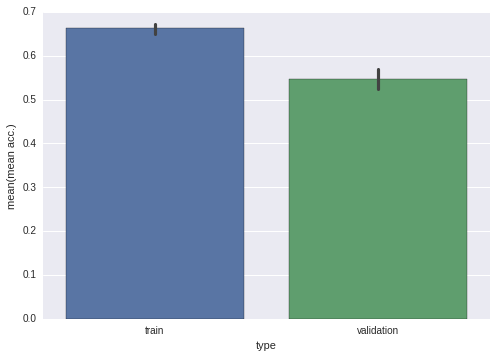

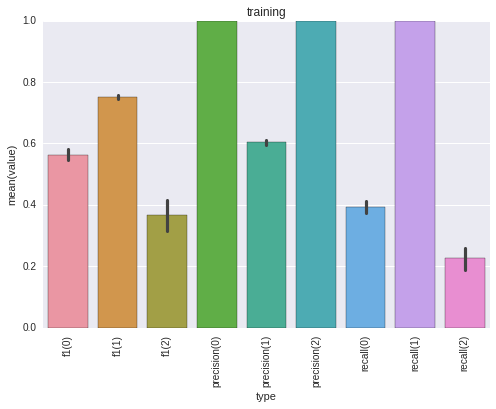

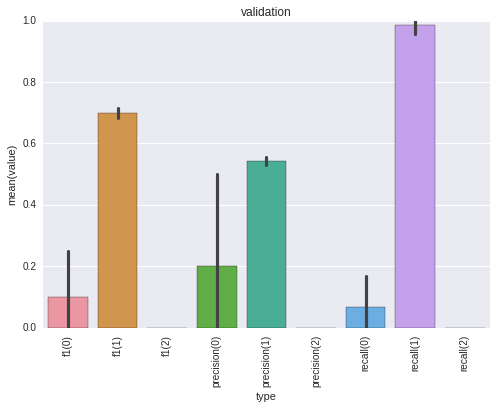

class: 0
	 10 course want
	 10 come want
	 10 got wrong
	 10 good let
	 9 going remember
	 8 data does
	 8 course thing
	 8 data server
	 6 equal means
	 6 goes way
	 5 function point
	 3 data structures
	 3 add method
	 2 didn really
	 1 able check
	 1 different value
class: 1
	 10 come want
	 10 going read
	 10 course thing
	 10 aren really
	 8 happen think
	 8 actually ve
	 7 course want
	 7 happens going
	 7 cause problems
	 7 don believe
	 5 bad thing
	 3 algorithm ll
	 3 add end
	 3 check number
	 2 different views
class: 2
	 10 come want
	 10 based information
	 10 course thing
	 10 did things
	 9 classes ve
	 9 different problems
	 8 example program
	 7 correct way
	 7 answer check
	 6 actually created
	 4 aren really
	 3 heavy lifting
	 2 columns rows
	 2 check links
	 2 graph let
	 1 doesn add


In [27]:
levels = pd.unique(df['level'])
t_w = list()

y = df['dig_level'].values
r = list()
top_n = 10
train_res = list()
valid_res = list()
pos_words = defaultdict(lambda :defaultdict(int))
for train_idx, test_idx in StratifiedShuffleSplit(y, n_iter=10, test_size=0.1, random_state=2016):
    x_train = vectorized_text[train_idx, :]
    x_test = vectorized_text[test_idx, :]
    y_train = y[train_idx]
    y_test = y[test_idx]

    clf = MultinomialNB(alpha=.5)
    clf.fit(x_train, y_train)
    r.append(('train', clf.score(x_train, y_train)))
    r.append(('validation', clf.score(x_test, y_test)))
    train_res.extend(evaluate(y_train, clf.predict(x_train)))
    valid_res.extend(evaluate(y_test, clf.predict(x_test)))

    log_prob = clf.feature_log_prob_
    for i in range(log_prob.shape[0]):
        s_lp_i = sorted(enumerate(log_prob[i, :]), key=itemgetter(1), reverse=True)
        s_lp_i = s_lp_i[:top_n]
        for idx in s_lp_i:
            w = words[idx[0]]
            pos_words[i][w] += 1
    
r = pd.DataFrame(columns=['type', 'mean acc.'], data=r)
ax = axes[t_idx]
sns.barplot(x='type', y='mean acc.', data=r)
#ax.xticks(rotation=90)
ax.set_title(target_class + " vs. all")
ax.set_ylim([.0, 1])
if t_idx > 0:
    ax.set_ylabel('')
plt.show()
viz_res(train_res, 'training')
viz_res(valid_res, 'validation')

for key, val_dict in sorted(pos_words.items(), key=itemgetter(0)):
    print('class:', key)
    for word, count in sorted(val_dict.items(), key=itemgetter(1), reverse=True):
        print('\t', count, word)